In [166]:
import json
import pandas as pd
import pickle
import numpy as np
import sys 
import xarray as xr
import matplotlib.pyplot as plt

sys.path.insert(0, "/gpfswork/rech/omr/uen17sn/NewSpinUp/lib")
import prepare
import stratification as strat

import importlib
importlib.reload(strat)

<module 'stratification' from '/gpfswork/rech/omr/uen17sn/NewSpinUp/lib/stratification.py'>

## **Load Data**

### 1.1 - Load zos

In [17]:
simu_nb  = 101
yearly   = True

zos_eof = prepare.createDataset(simu_nb,yearly)
zos_pca = prepare.loadPCA(simu_nb,yearly)

### 1.2 - Load scsaltot and so

In [18]:
from simu_path import path1 

path       = path1                 
time_dim   = "time_counter"        
grid_term  = ["scsaltot.nc","so.nc"]              
cut_simu   = 45                    

if yearly==False: 
    cut_simu = cut_simu*12

In [19]:
salinite_data = prepare.getData(path, term = grid_term)

scsaltot_data = xr.open_dataset(salinite_data["scsaltot.nc"][-1],decode_times=False)
so_data       = xr.open_dataset(salinite_data["so.nc"][-1],decode_times=False)

lon = so_data.nav_lon.values
lat = so_data.nav_lat.values

In [20]:
depth_dim  = "olevel"
so_data.so

<xarray.DataArray 'so' (time_counter: 600, olevel: 75, y: 332, x: 362)>
[5408280000 values with dtype=float32]
Coordinates:
    nav_lat        (y, x) float32 -84.21 -84.21 -84.21 ... 50.23 50.01 50.01
    nav_lon        (y, x) float32 72.5 73.5 74.5 75.5 ... 73.05 73.04 73.0 72.99
  * olevel         (olevel) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  (time_counter) float64 ...
  * time_counter   (time_counter) float64 6.313e+09 6.315e+09 ... 7.888e+09
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_practical_salinity
    long_name:           sea_water_salinity
    units:               0.001
    online_operation:    average
    interval_operation:  1 month
    interval_write:      1 month
    cell_methods:        time: mean
    cell_measures:       area: area

In [21]:
scsaltot_data.scsaltot

<xarray.DataArray 'scsaltot' (time_counter: 3000, y: 1, x: 1)>
[3000 values with dtype=float32]
Coordinates:
  * time_counter  (time_counter) float64 1.339e+06 3.888e+06 ... 7.888e+09
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_salinity
    long_name:           global mean salinity
    units:               1e-3
    online_operation:    average
    interval_operation:  2700 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 2700 s)
    cell_measures:       area: area
    coordinates:         time_centered nav_lat nav_lon

## **Scaltot**

In [22]:
df = pd.DataFrame(np.array(scsaltot_data.scsaltot[:,0,0]),columns=["scsaltot"])

Text(0.5, 1.0, 'Global Mean salinity')

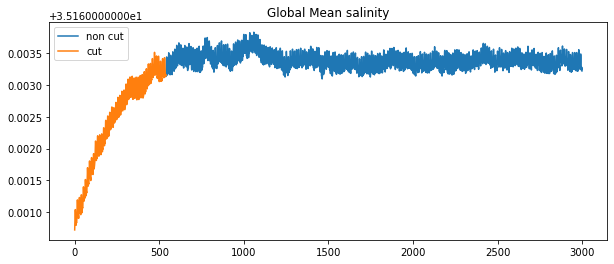

In [23]:
fig = plt.figure(figsize=(10,4))
plt.plot(df.index[cut_simu*12:],df.scsaltot[cut_simu*12:],label="non cut")
plt.plot(df.scsaltot[:cut_simu*12],label="cut")
plt.legend()
plt.title("Global Mean salinity")

In [24]:
df = pd.DataFrame(np.array(scsaltot_data.scsaltot[cut_simu*12:,0,0]),columns=["scsaltot"])

Text(0.5, 1.0, 'Global Mean salinity')

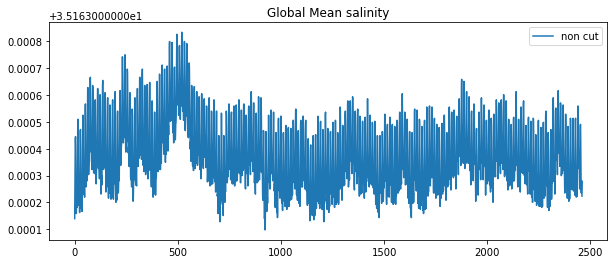

In [25]:
fig = plt.figure(figsize=(10,4))
plt.plot(df.scsaltot[:],label="non cut")
plt.legend()
plt.title("Global Mean salinity")

In [26]:
f"{(0.0008/35)*100}%"

'0.002285714285714286%'

Variation de la salinité global de moins de 0,002%

## **So**

### 3.1 - Compute global mean

In [27]:
dico = prepare.toDictionnary(grid     = salinite_data["so.nc"],
                             dtime    = "time_counter", 
                             nb_dim   = 4, 
                             filter   = ["so"],
                             yearly   = yearly,
                             cut_simu = cut_simu,
                             mean_dim = depth_dim ,
                             n_jobs   = 1)  

### 3.1 - Method 1 : Apply pca on so global mean

(205, 55)


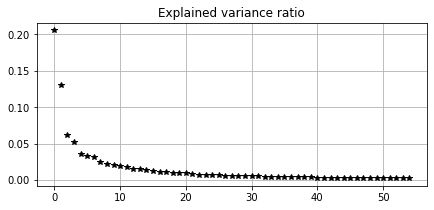

In [137]:
so1            = np.array(dico["features"]["so"])
so1,pca1,mask1 = strat.toTimeSeries(so1,0.90)

fig = plt.figure(figsize=(7,3))
plt.plot(pca_so.explained_variance_ratio_,"k*")
plt.title("Explained variance ratio")
plt.grid()

print(np.shape(so1))

In [31]:
method1 = {
    "features" :{"so":so1},
    "mean"     :{"so":dico["mean"]["so"]},
    "std"      :{"so":dico["std"]["so"]},
    "mask"     :{"so":mask1},
    "pca"      :{"so":pca1}}

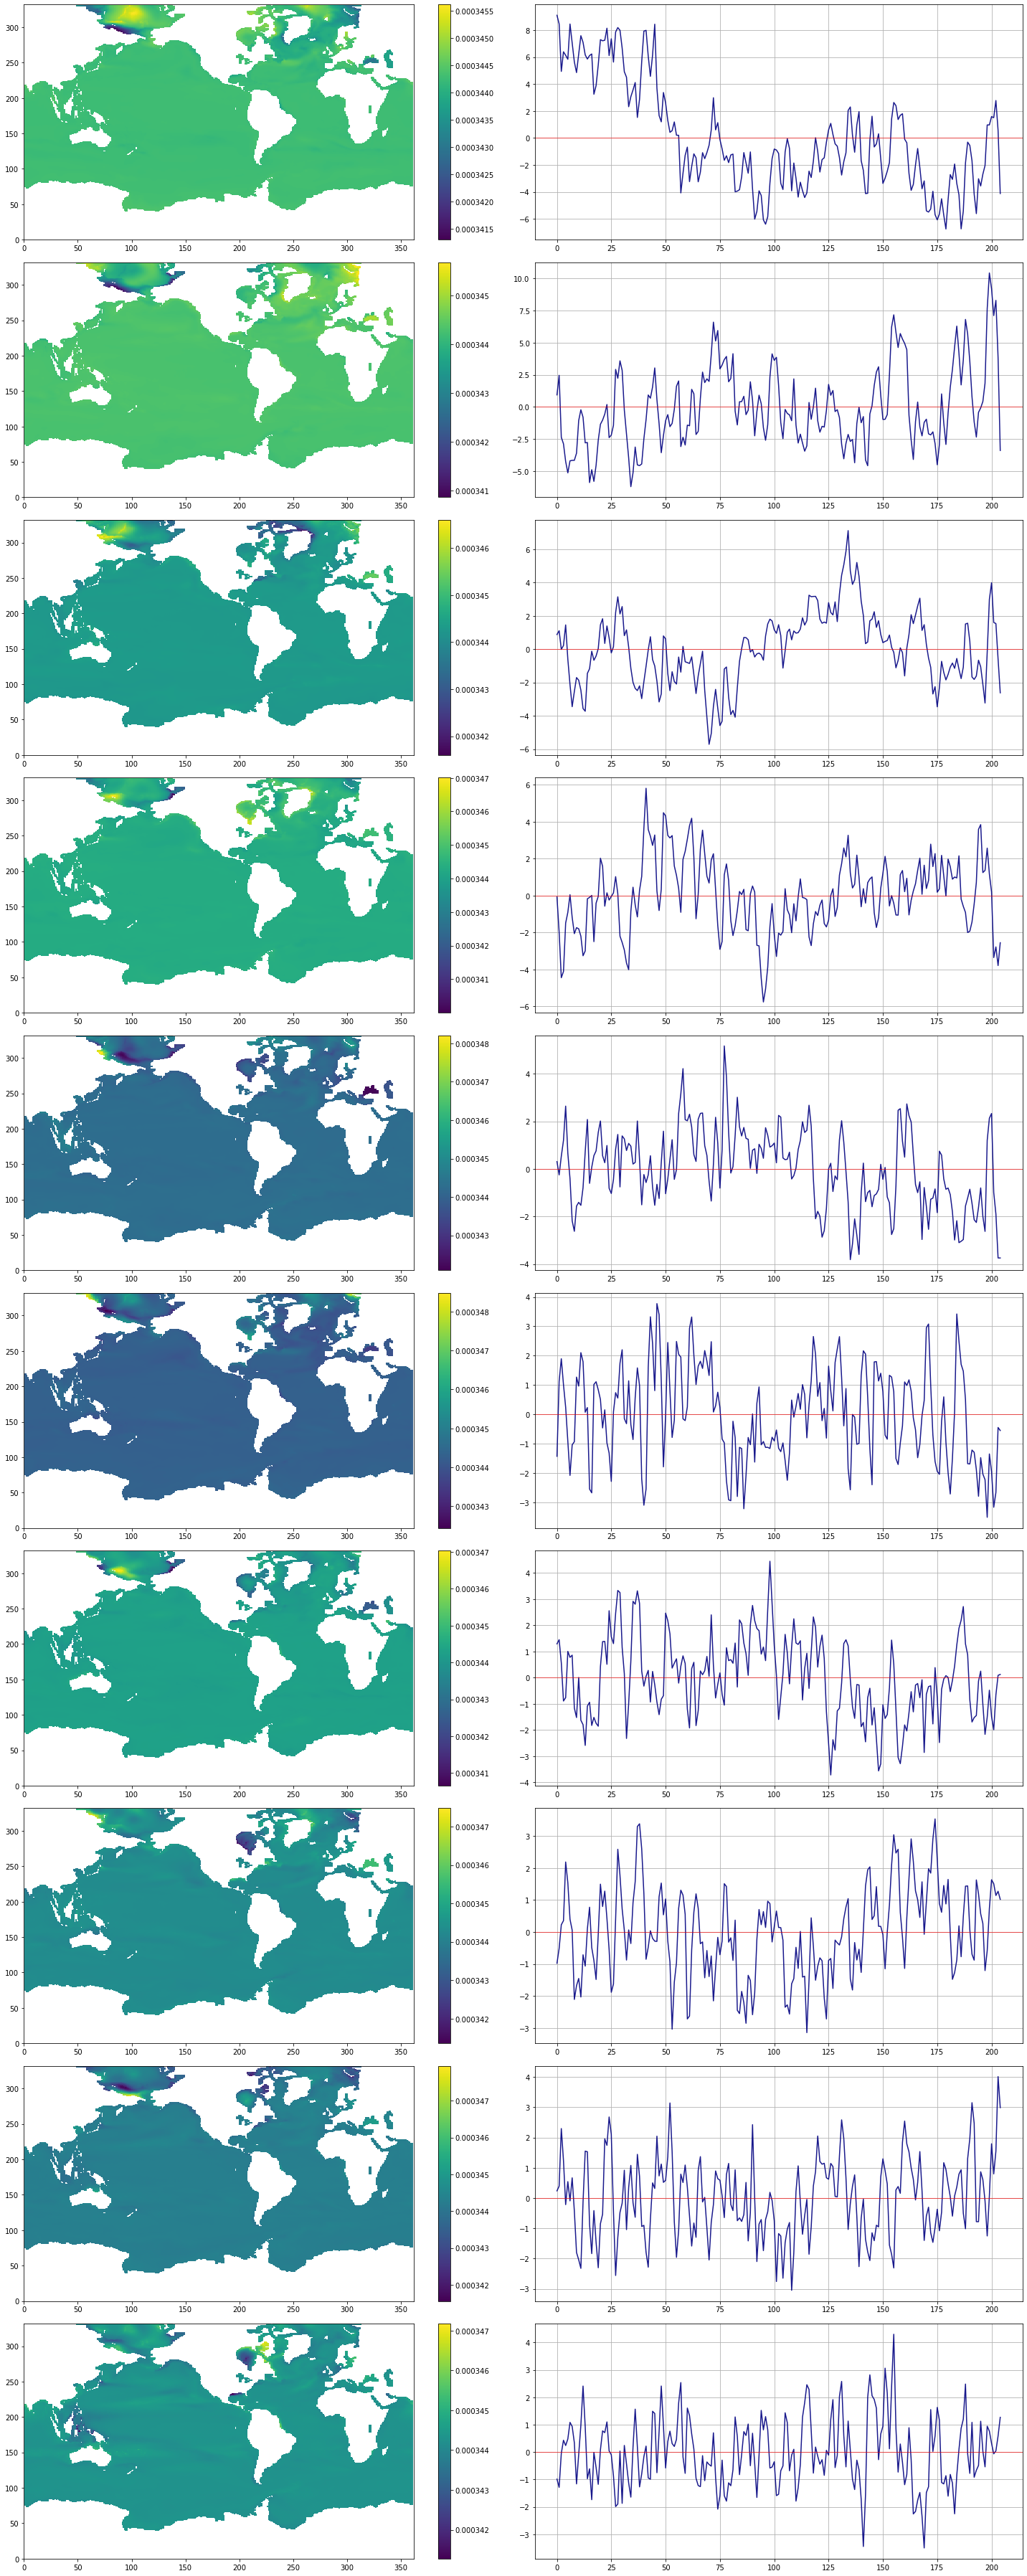

In [167]:
strat.plot_all(method1,10)

In [140]:
print(f"Les 9 premiers modes pour cette simulation represente explique le comportement de la salinité en arctique soit {np.sum(pca_so.explained_variance_ratio_[0:8])*100}%")

Les 9 premiers modes pour cette simulation represente explique le comportement de la salinité en arctique soit 57.44467189193192%


### 3.2 - Method 2 : Compute zos pca on so global mean

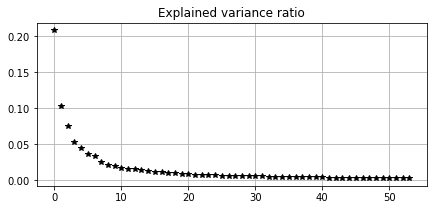

In [141]:
so2       = np.array(dico["features"]["so"])
so2,mask2 = strat.toTimeSeries(so2,pca=zos_pca["zos"])

fig = plt.figure(figsize=(7,3))
plt.plot(zos_pca["zos"].explained_variance_ratio_,"k*")
plt.title("Explained variance ratio")
plt.grid()

In [40]:
method2 = {
    "features" :{"so":so2},
    "mean"     :{"so":dico["mean"]["so"]},
    "std"      :{"so":dico["std"]["so"]},
    "mask"     :{"so":mask2},
    "pca"      :{"so":zos_pca["zos"]}}

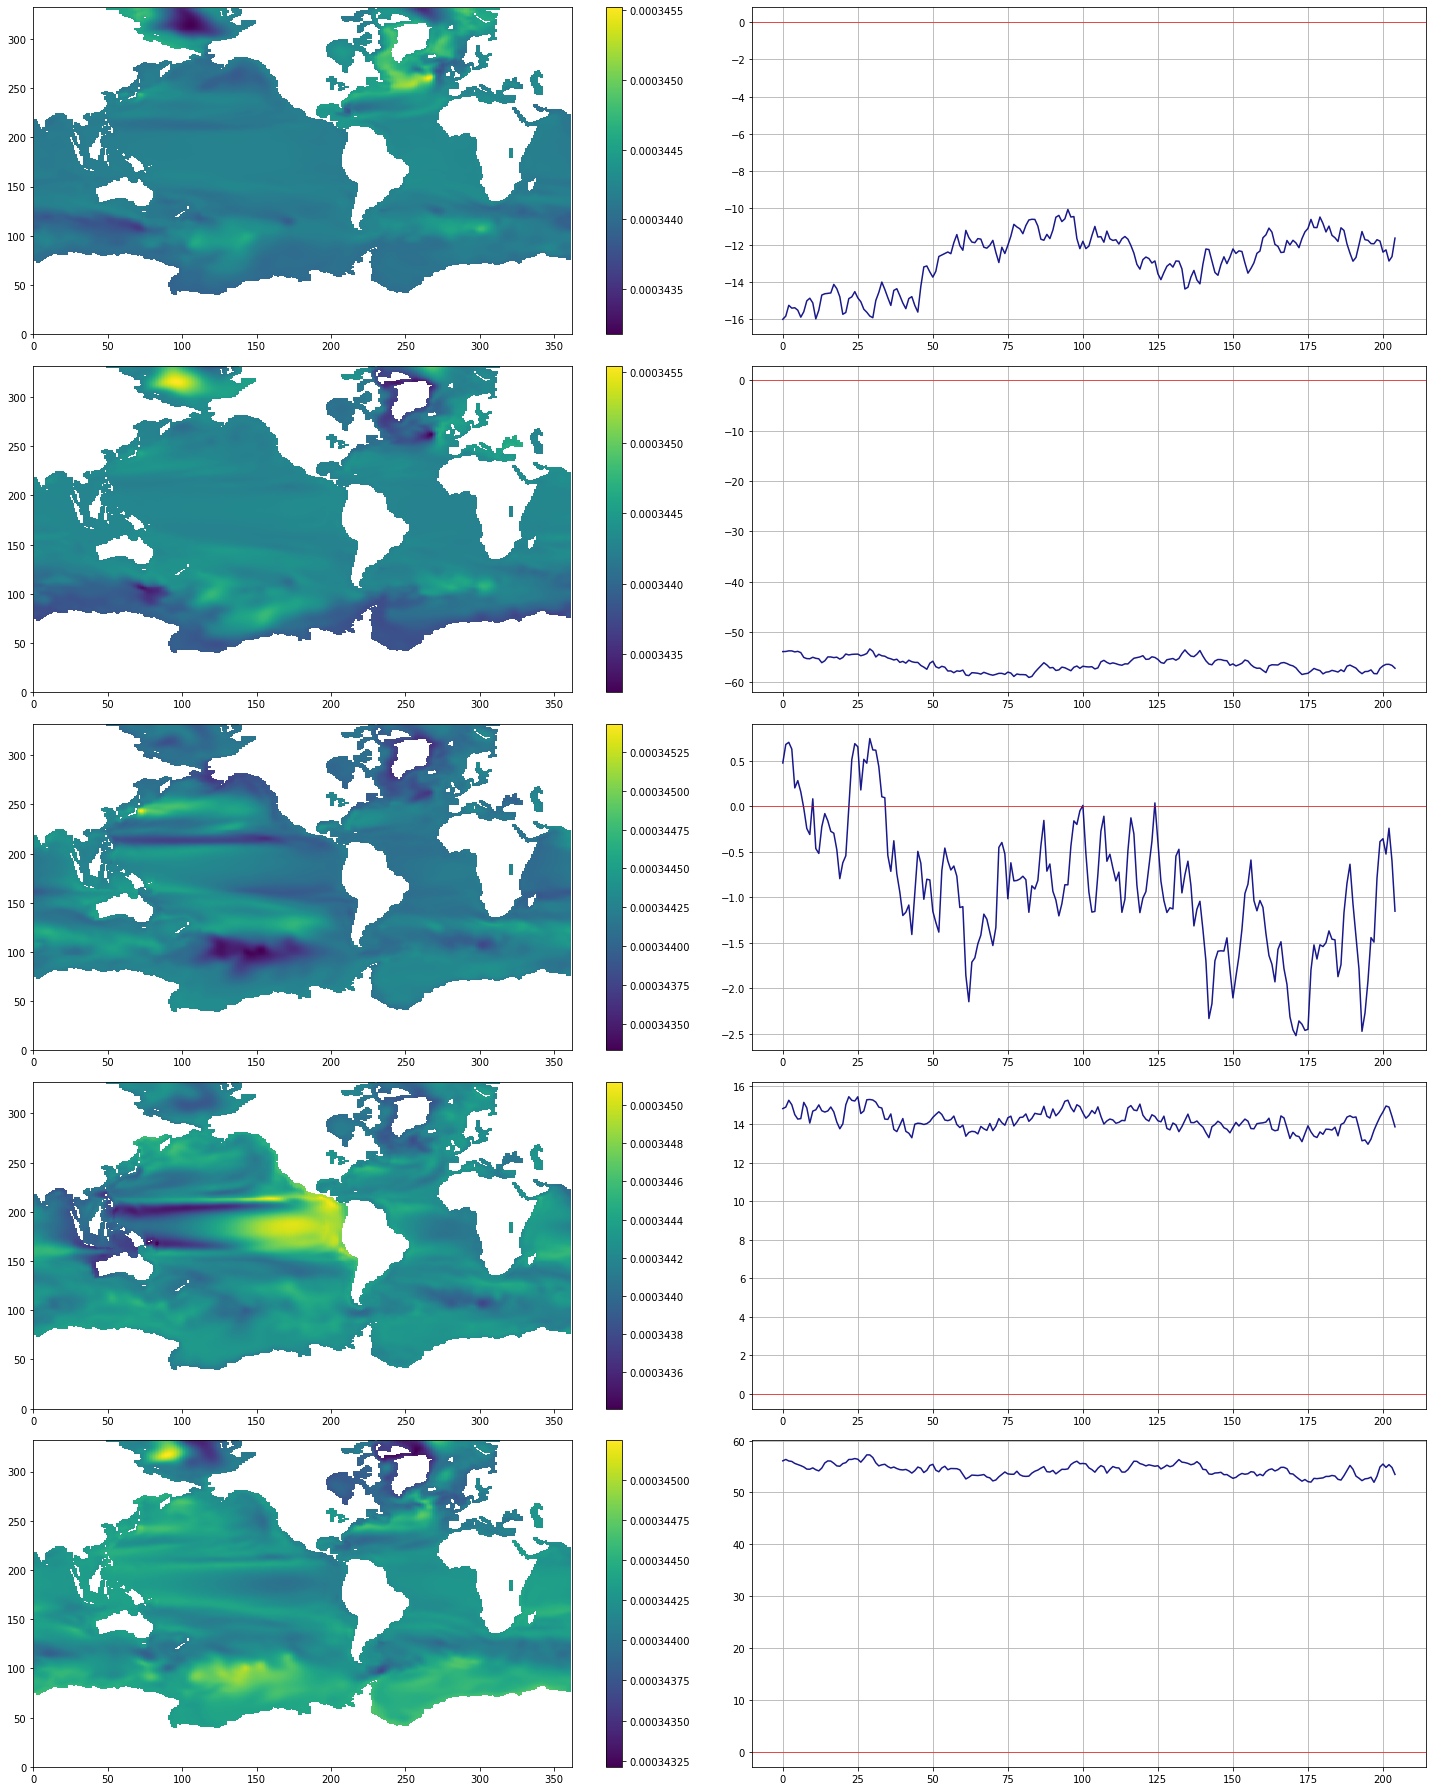

In [72]:
strat.plot_all(method2,5)

In [ ]:
PB m / salinité diff ordre de grandeurs qu'en penser

### 3.2 - Method 3 : Regional separation

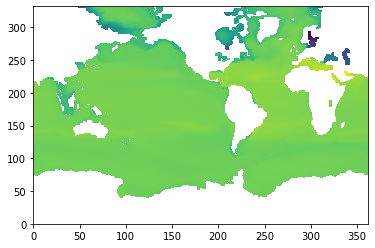

In [43]:
plt.pcolor(dico["features"]["so"][0])

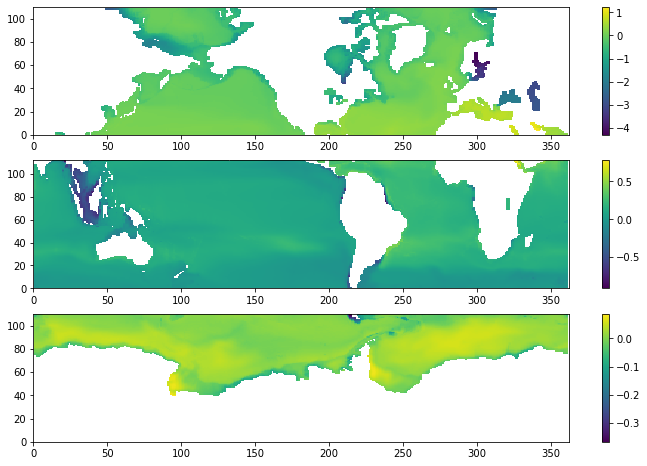

In [96]:
sep = 332//3

fig, ax = plt.subplots(3,1,figsize=(12,8))
im0 = ax[0].pcolor(dico["features"]["so"][0][-sep:,:])
im1 = ax[1].pcolor(dico["features"]["so"][0][sep:-sep,:])
im2 = ax[2].pcolor(dico["features"]["so"][0][:sep,:])

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
fig.colorbar(im2, ax=ax[2])

Moyennes

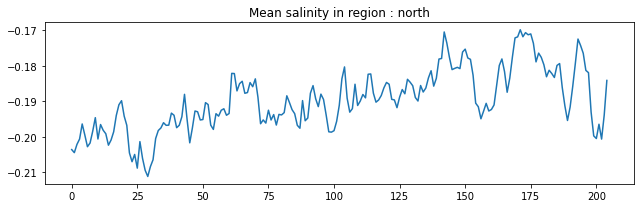

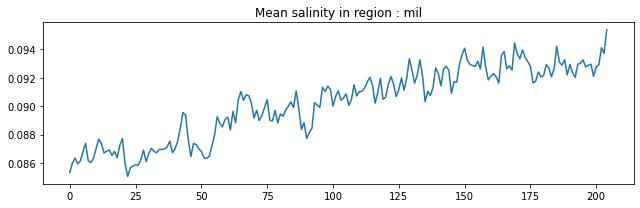

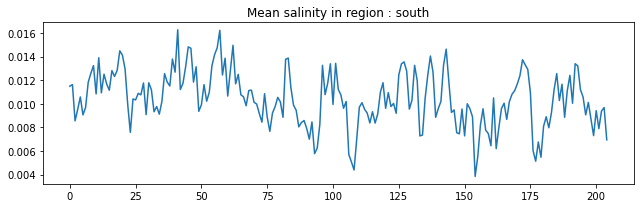

In [145]:
sep  = 110

nord = np.nanmean(dico["features"]["so"][:,-sep:,:],axis=(1,2))
mil  = np.nanmean(dico["features"]["so"][:,sep:-sep,:],axis=(1,2))
sud  = np.nanmean(dico["features"]["so"][:,:sep,:],axis=(1,2))

regions = [nord,mil,sud]
names   = ["north","mil","south"]

for i in range(len(regions)):
    fig = plt.figure(figsize=(9,3))
    plt.plot(regions[i])
    plt.title(f"Mean salinity in region : {names[i]}")
    plt.tight_layout()
    plt.show()

Regions shapes before and after pca
 - North (205, 110, 362)  => (205, 40)
 - Mil (205, 112, 362)    => (205, 62)
 - South (205, 110, 362)  => (205, 47)


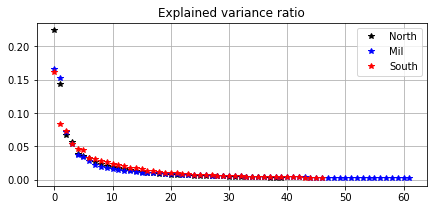

In [197]:
nordred,pca_nord,mask_nord = strat.toTimeSeries(dico["features"]["so"][:,-sep:,:],0.9)
milred,pca_mil,mask_mil    = strat.toTimeSeries(dico["features"]["so"][:,sep:-sep,:],0.9)
sudred,pca_sud,mask_sud    = strat.toTimeSeries(dico["features"]["so"][:,:sep,:],0.9)

fig = plt.figure(figsize=(7,3))
plt.plot(pca_nord.explained_variance_ratio_,"k*",label = "North")
plt.plot(pca_mil.explained_variance_ratio_,"b*",label = "Mil")
plt.plot(pca_sud.explained_variance_ratio_,"r*",label = "South")
plt.title("Explained variance ratio")
plt.legend()
plt.grid()

print("Regions shapes before and after pca")
print(f" - North {np.shape(dico['features']['so'][:,-sep:,:])}  => {np.shape(nordred)}")
print(f" - Mil {np.shape(dico['features']['so'][:,sep:-sep,:])}    => {np.shape(milred)}")
print(f" - South {np.shape(dico['features']['so'][:,:sep,:])}  => {np.shape(sudred)}")

In [119]:
method3 = {
    "features" :{"sonord":nordred,            "somil":milred,             "sosud":sudred},
    "mean"     :{"sonord":dico["mean"]["so"], "somil":dico["mean"]["so"], "sosud":dico["mean"]["so"]},
    "std"      :{"sonord":dico["std"]["so"],  "somil":dico["std"]["so"],  "sosud":dico["std"]["so"]},
    "mask"     :{"sonord":mask_nord,          "somil":mask_mil,           "sosud":mask_sud},
    "pca"      :{"sonord":pca_nord,           "somil":pca_mil,            "sosud":pca_sud}}

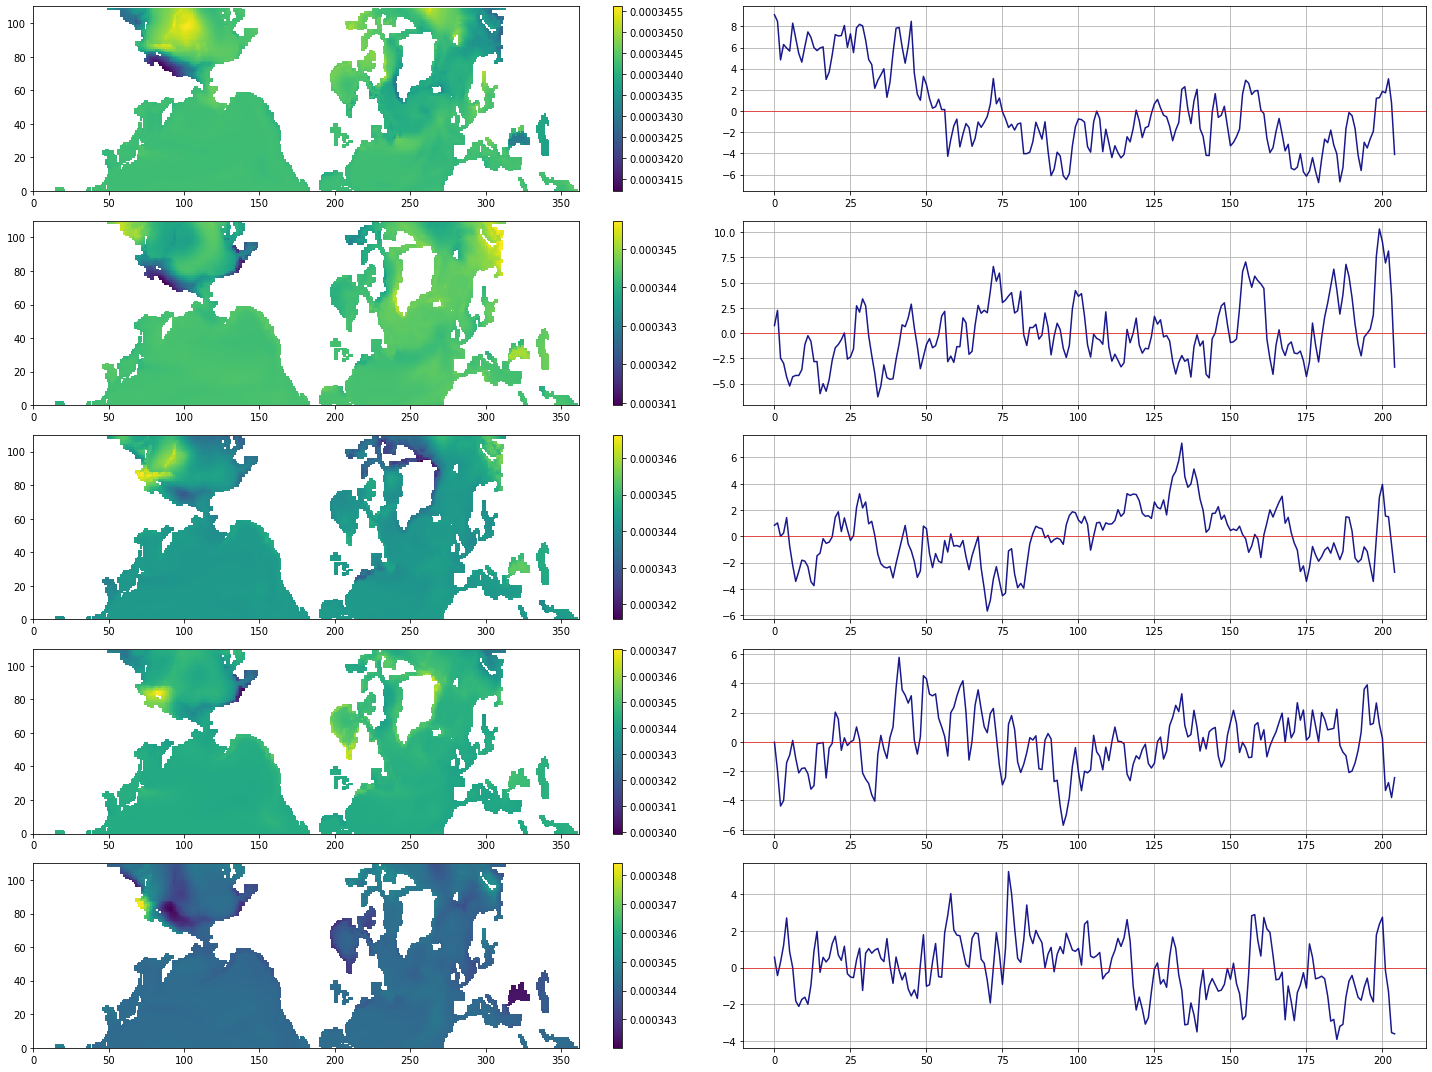

In [168]:
strat.plot_all(method3,5,"sonord",shape=(110,362),mult=3)

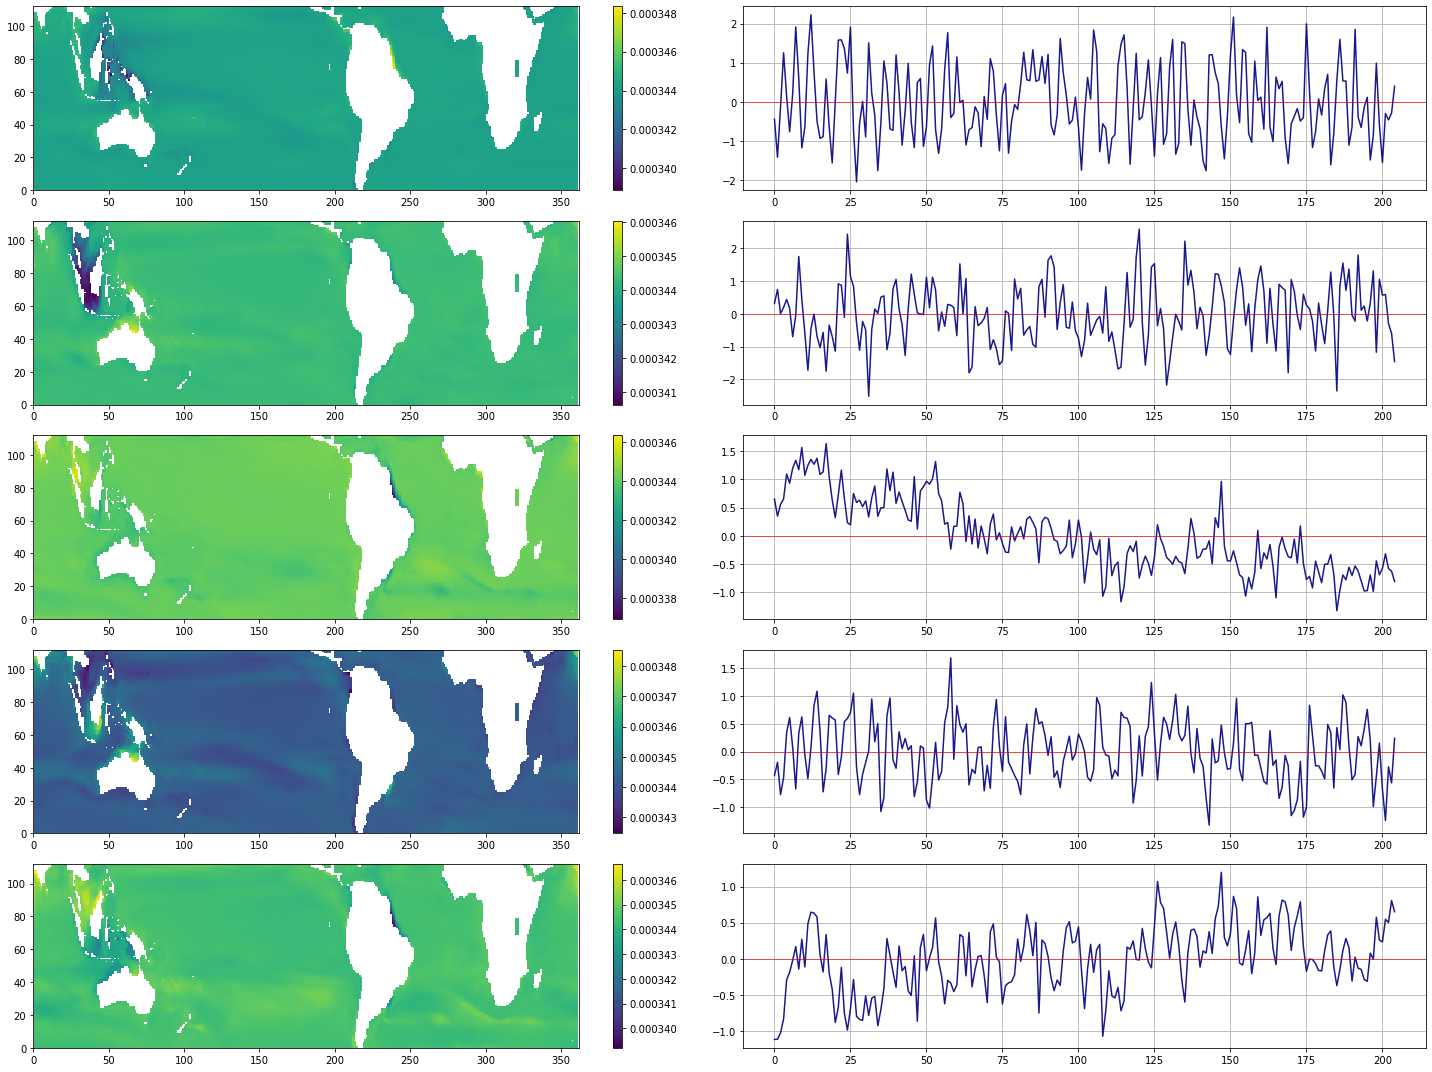

In [169]:
strat.plot_all(method3,5,"somil",shape=(112,362),mult=3)

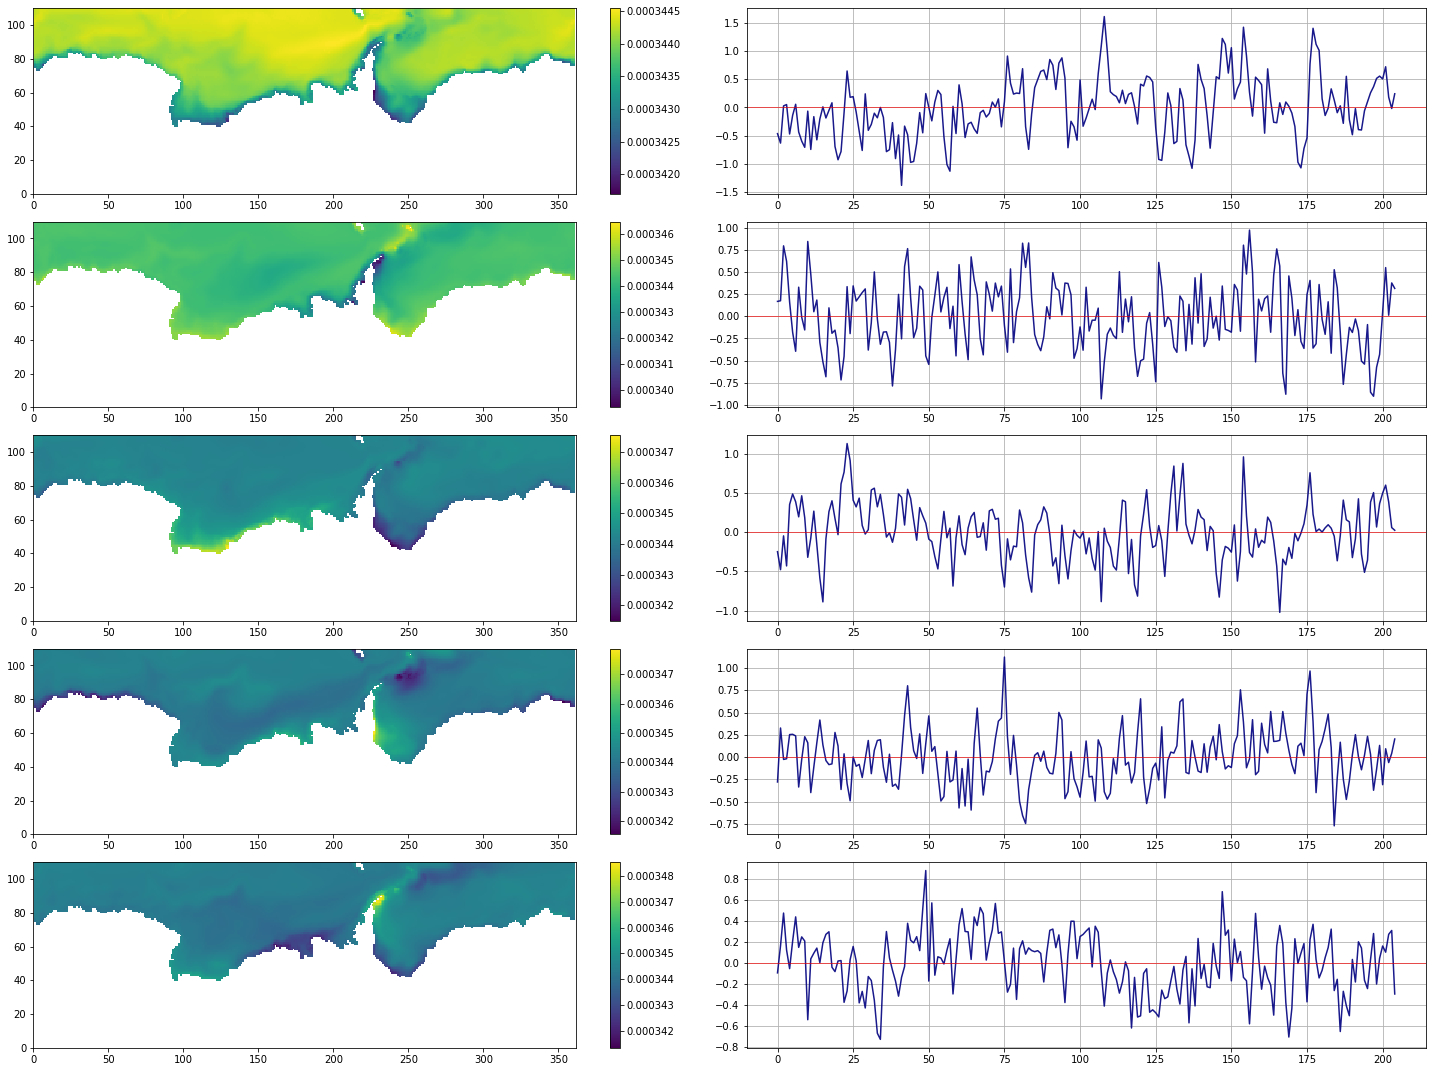

In [170]:
strat.plot_all(method3,5,"sosud",shape=(110,362),mult=3)

### 3.3 - Method 4 : Surface-bottom / variance separation

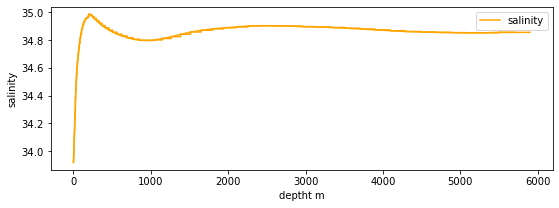

In [74]:
so_z   = so_data.so[0:20].mean(dim=["time_counter","x","y"],skipna=True)
new_so = strat.extend_values(so_z.values,so_z.olevel.values)

fig = plt.figure(figsize=(9,3))
plt.plot(so_data.olevel,so_z,label="salinity",color="orange")
plt.plot(new_so,color="orange")
plt.xlabel("deptht m")
plt.ylabel("salinity")
plt.legend()
plt.show()

mode: 26


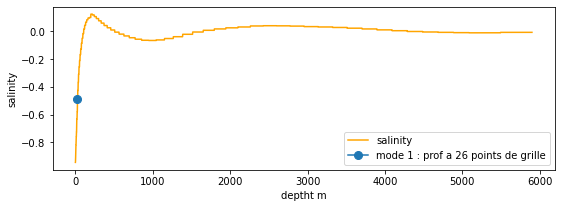

In [199]:
so      = new_so - np.nanmean(new_so)
min_var = strat.min_var(so,0)[1]
print("mode:",min_var)

fig = plt.figure(figsize=(9,3))
plt.plot(so,label="salinity",color="orange")
plt.plot(min_var,so[min_var], marker="o", markersize=8,label=f"mode 1 : prof a {min_var} points de grille")
plt.xlabel("deptht m")
plt.ylabel("salinity")
plt.legend()
plt.show()

simu shape: (205, 332, 362)

Surface shape after pca: (205, 56)
Bottom shape after pca:  (205, 45)


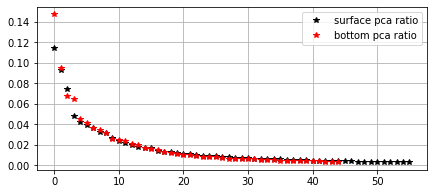

In [201]:
so_surf_bott = np.array(Parallel(n_jobs=3)(delayed(strat.mode1)(sim,"so",26) for sim in salinite_data["so.nc"]))
surf         = [so_var[i,0] for i in range(len(salinite_data["so.nc"]))]
bott         = [so_var[i,1] for i in range(len(salinite_data["so.nc"]))]

surface,msurf,stdsurf = strat.prepare(np.nanmean(np.concatenate(surf,axis=0)[cut_simu*12:].reshape(12,-1,332,362),axis=0))
bottom ,mbott,stdbott = strat.prepare(np.nanmean(np.concatenate(bott,axis=0)[cut_simu*12:].reshape(12,-1,332,362),axis=0))

print("simu shape:",np.shape(surface))

sosurf,pcasurf,masksurf = toTimeSeries(surface,0.90)
sobott,pcabott,maskbott = toTimeSeries(bottom,0.90)

print("\nSurface shape after pca:",np.shape(sosurf))
print("Bottom shape after pca: "   ,np.shape(sobott))

fig = plt.figure(figsize=(7,3))
plt.plot(pcasurf.explained_variance_ratio_,"k*",label = "surface pca ratio")
plt.plot(pcabott.explained_variance_ratio_,"r*",label = "bottom pca ratio")
plt.grid();
plt.legend();

In [77]:
method4 = {
    "features" :{"so_surface":sosurf,"so_bottom":sobott},
    "mean"     :{"so_surface":msurf,"so_bottom":mbott},
    "std"      :{"so_surface":stdsurf,"so_bottom":stdbott},
    "mask"     :{"so_surface":masksurf,"so_bottom":maskbott},
    "pca"      :{"so_surface":pcasurf,"so_bottom":pcabott}}

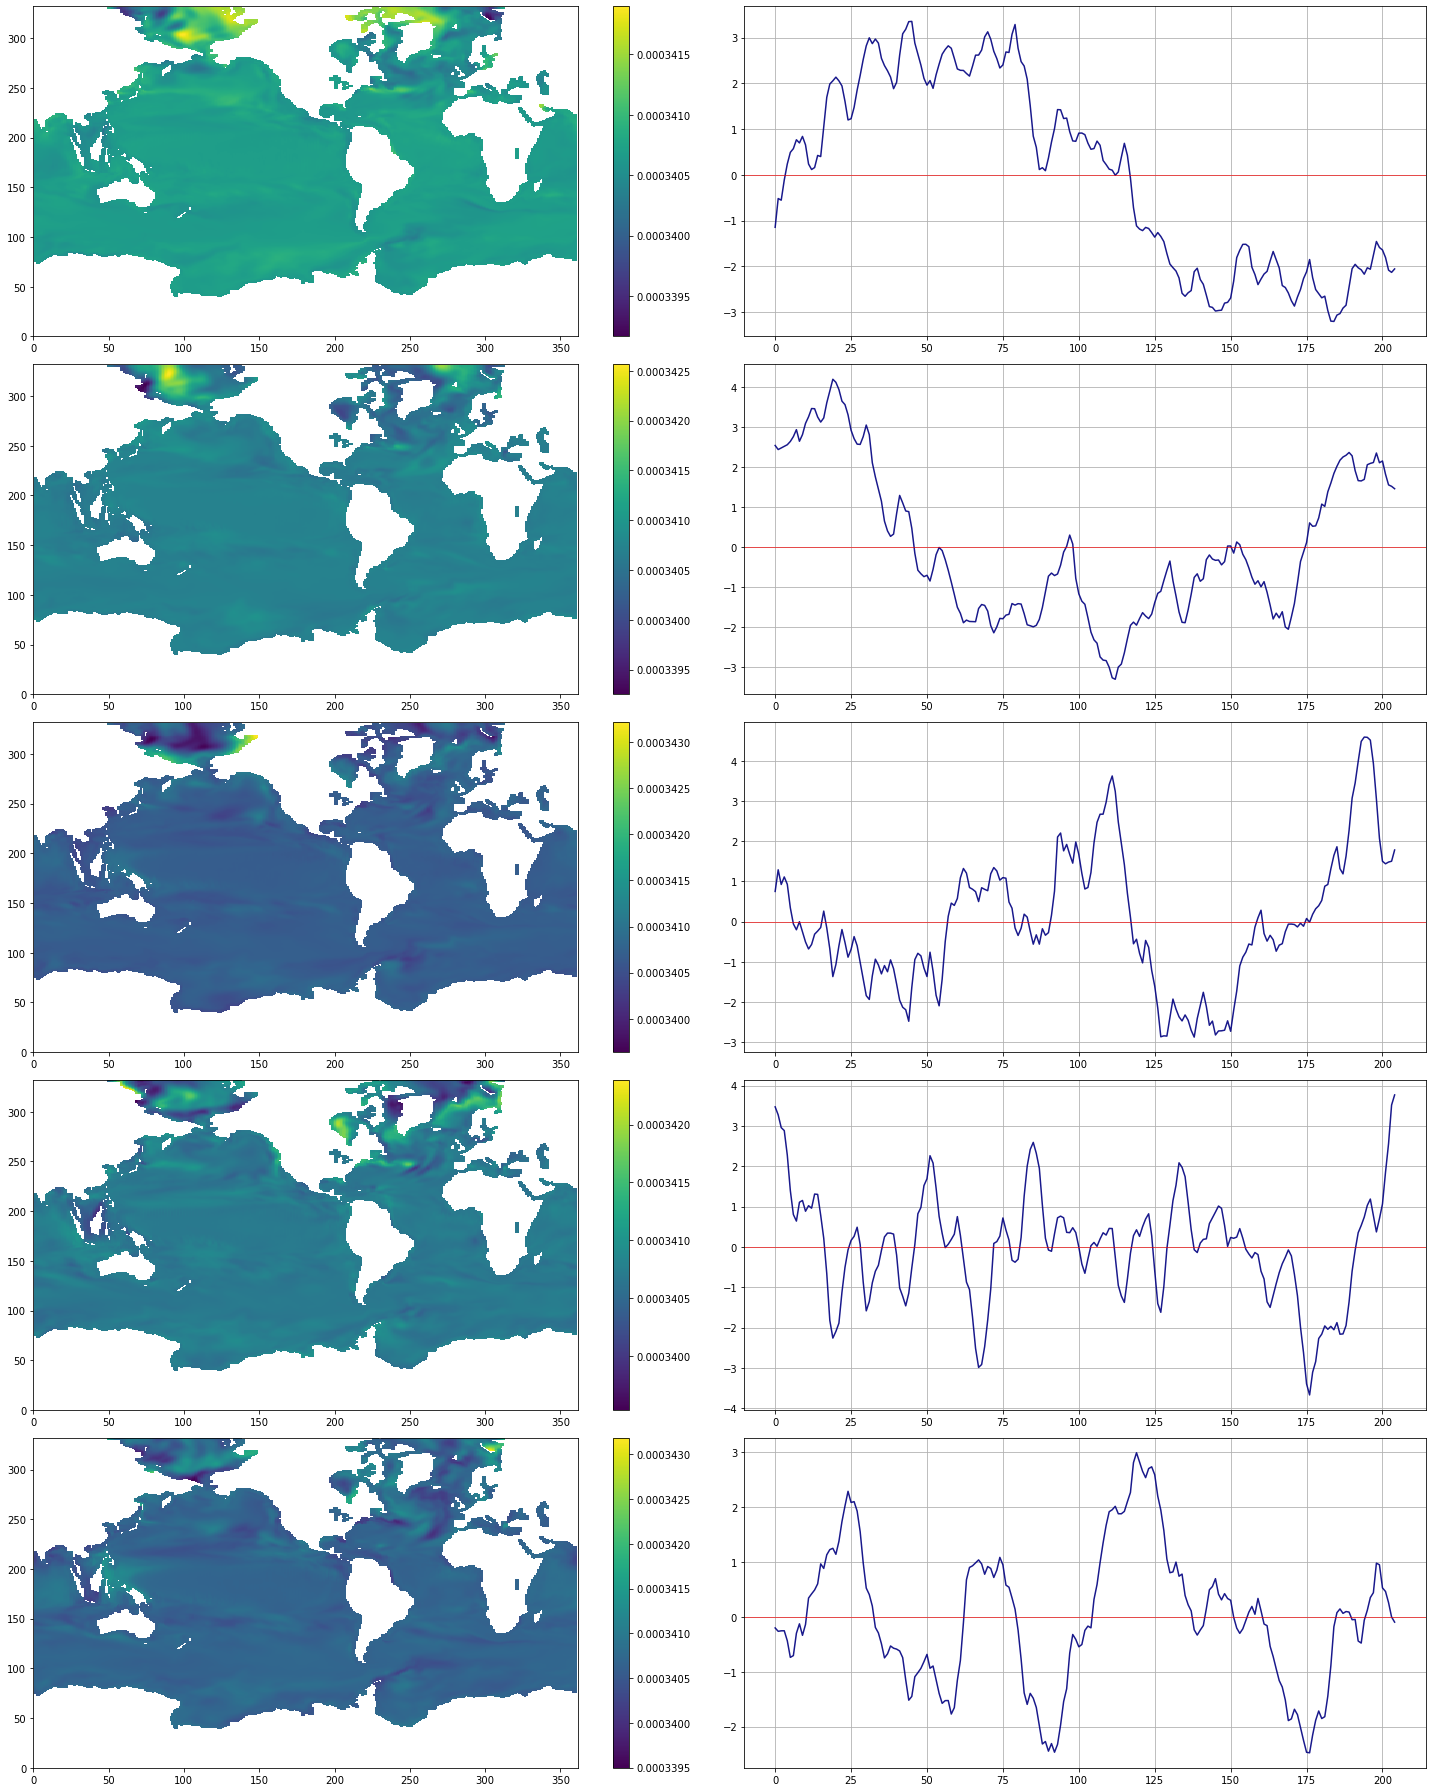

In [171]:
strat.plot_all(method4,n=5,var="so_surface")

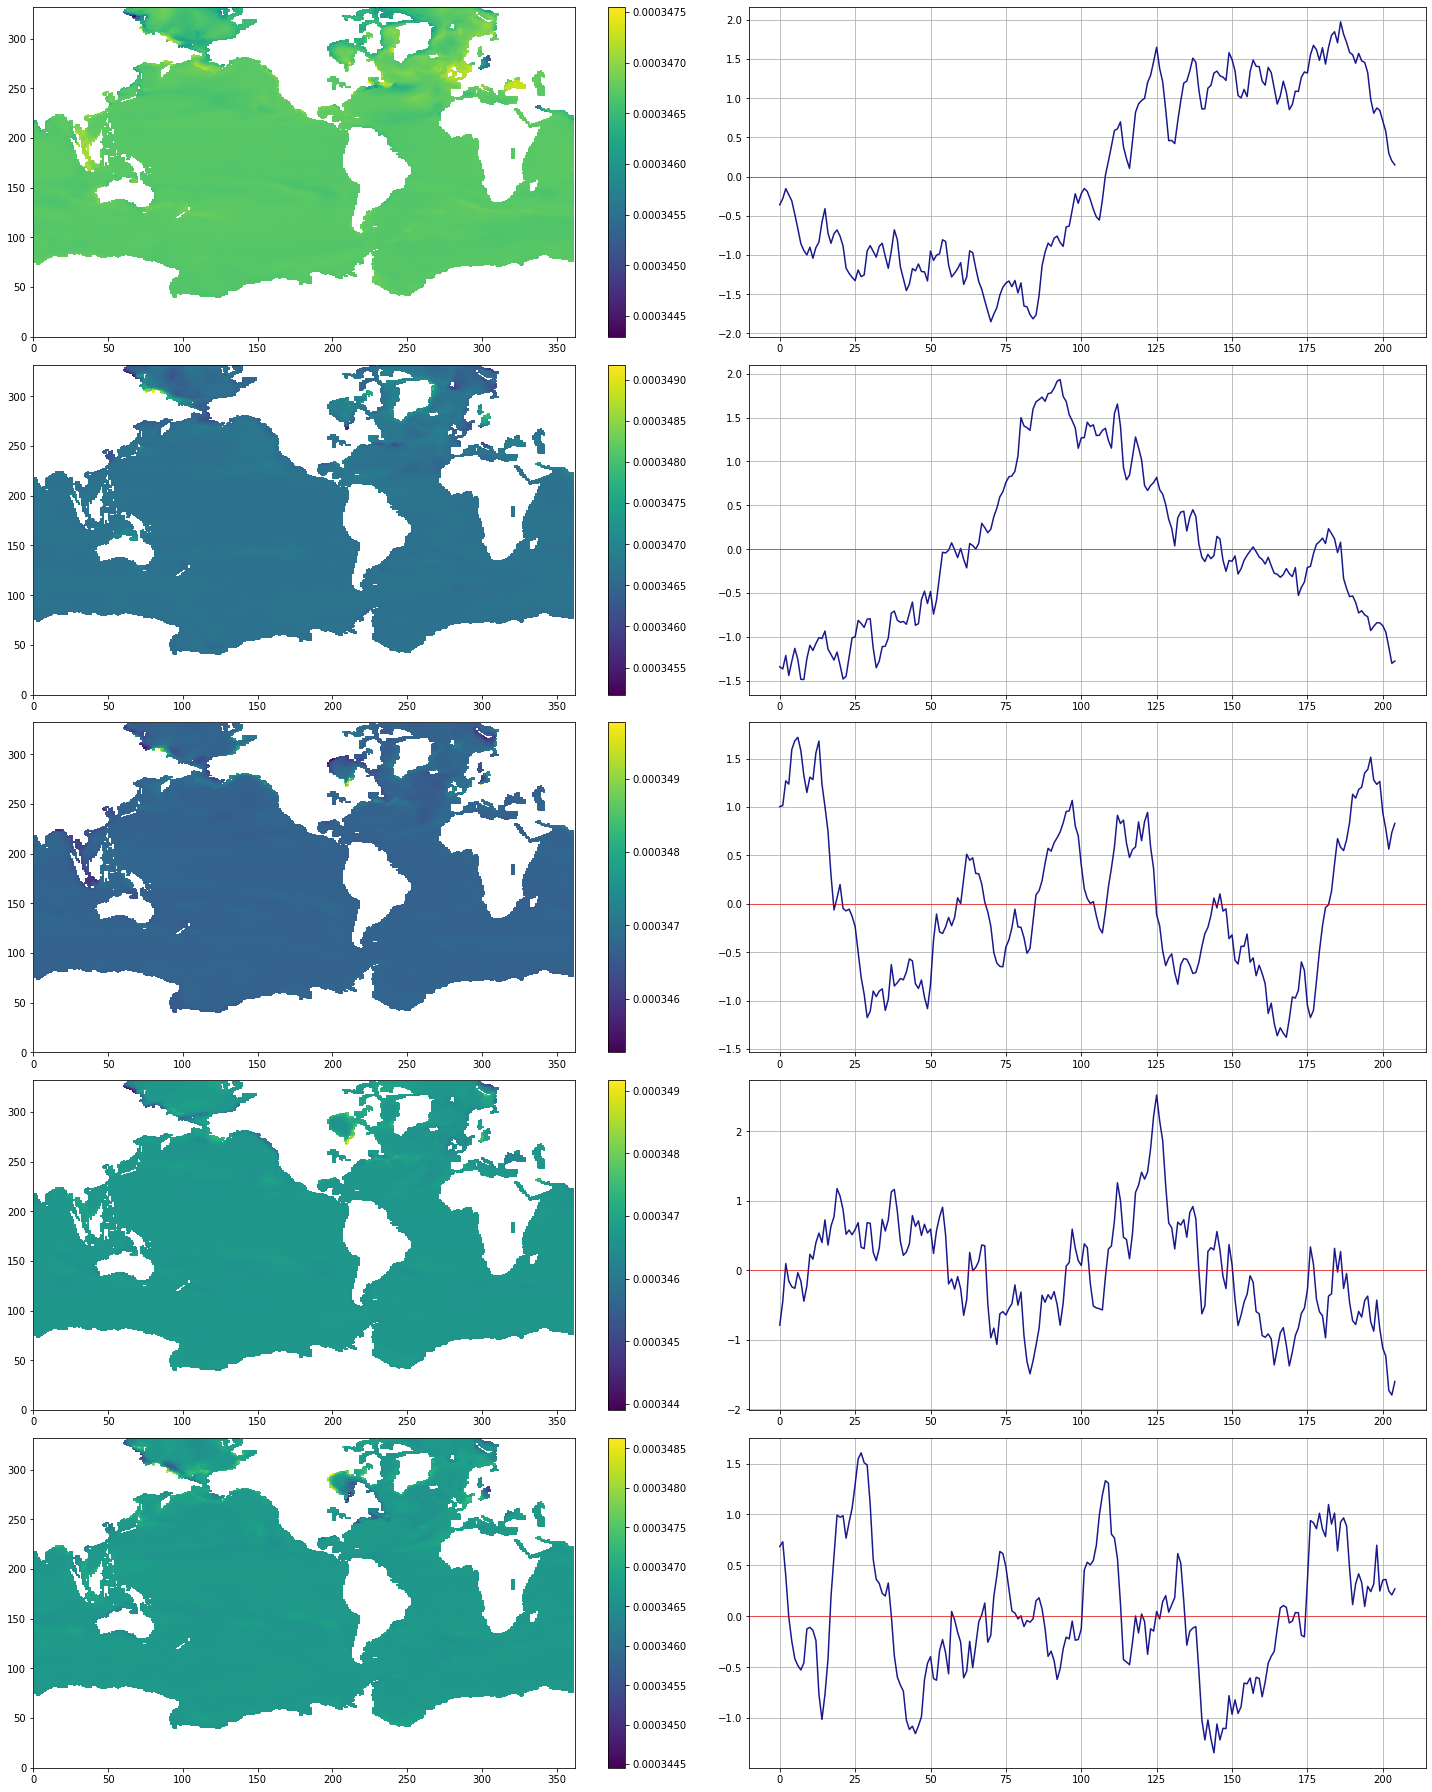

In [172]:
strat.plot_all(method4,n=5,var="so_bottom")

## **Correlation zos / so**
Valeur de la correlation au temps t / à l'ecart de temps t
corr = (fft(sig1)xfft(sig2))-1

### 1.1 - 